In [40]:
import xarray as xr
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.gridspec as gridspec


import os, sys
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))

import open_data
from dask.distributed import wait, Client

In [12]:
# client.close()

In [13]:
client = Client(n_workers=12, threads_per_worker=1, memory_limit=None) 
# client.close()
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.11/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37411 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/37411/status,
Dashboard: /proxy/37411/status,Workers: 12
Total threads: 12,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44813,Workers: 0
Dashboard: /proxy/37411/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:36361,Total threads: 1
Dashboard: /proxy/39965/status,Memory: 0 B
Nanny: tcp://127.0.0.1:40927,


In [14]:
data_ds = open_data.open_best().persist()
wait(data_ds);

Opening best dataset from - /g/data/w40/ab2313/time_of_emergence/best/Land_and_Ocean_LatLong1_time_chunk.zarr
  -- overriding time to use cftime
  -- resampling to yearly mean


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.11/lib/python3.11/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 43.26 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [21]:
data_ds

<xarray.DataArray 'temperature' (time: 175, lat: 180, lon: 360)> Size: 45MB
dask.array<xarray-<this-array>, shape=(175, 180, 360), dtype=float32, chunksize=(175, 90, 120), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1kB 1850-12-31 00:00:00 ... 2024-12-31 00:00:00
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Attributes:
    long_name:      Air Surface Temperature Anomaly
    standard_name:  surface_temperature_anomaly
    units:          degree C
    valid_max:      25.701491748794503
    valid_min:      -20.130122807817852
    dataset_name:   best

In [18]:
data_ds_base_period = data_ds.sel(time=slice('1850', '1899')).mean(dim='time')

In [20]:
data_ds_anom = data_ds - data_ds_base_period

In [22]:
data_ds_anom

<xarray.DataArray 'temperature' (time: 175, lat: 180, lon: 360)> Size: 45MB
dask.array<sub, shape=(175, 180, 360), dtype=float32, chunksize=(175, 90, 120), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1kB 1850-12-31 00:00:00 ... 2024-12-31 00:00:00
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

In [33]:
data_ds_anom_final = data_ds_anom.isel(time=-1).compute()

In [56]:
# from plotting_utils import hatch

In [85]:
def add_data_clarity_legend(ax,
                            bbox_to_anchor=(0.42, -0.02),
                            fontsize=10, ncol=1, fontscale=1):
    """
    Add legend for clarity markers (choose with `elements`).
    elements: tuple of indices (0='Not Enough Data', 1='Does Not Emerge')
    """
    element = plt.Rectangle([0, 0], 1, 1, fc='white', hatch='//', edgecolor='black', lw=0.5),
    
    label = ['Not Enough Data']
    
    legend = ax.legend(
        element, label, loc='upper center',
        bbox_to_anchor=bbox_to_anchor, fontsize=fontsize*fontscale, ncol=ncol
    )
    return legend


In [84]:
def hatch(ax, ds, **kwargs):

    LON, LAT = np.meshgrid(ds.lon.values, ds.lat.values)
    ax.contourf(LON, LAT, ds.values, levels=[0.5, 1.5], 
                transform=ccrs.PlateCarree(), **kwargs)

In [84]:
def hatch(ax, ds, **kwargs):

    LON, LAT = np.meshgrid(ds.lon.values, ds.lat.values)
    ax.contourf(LON, LAT, ds.values, levels=[0.5, 1.5], 
                transform=ccrs.PlateCarree(), **kwargs)

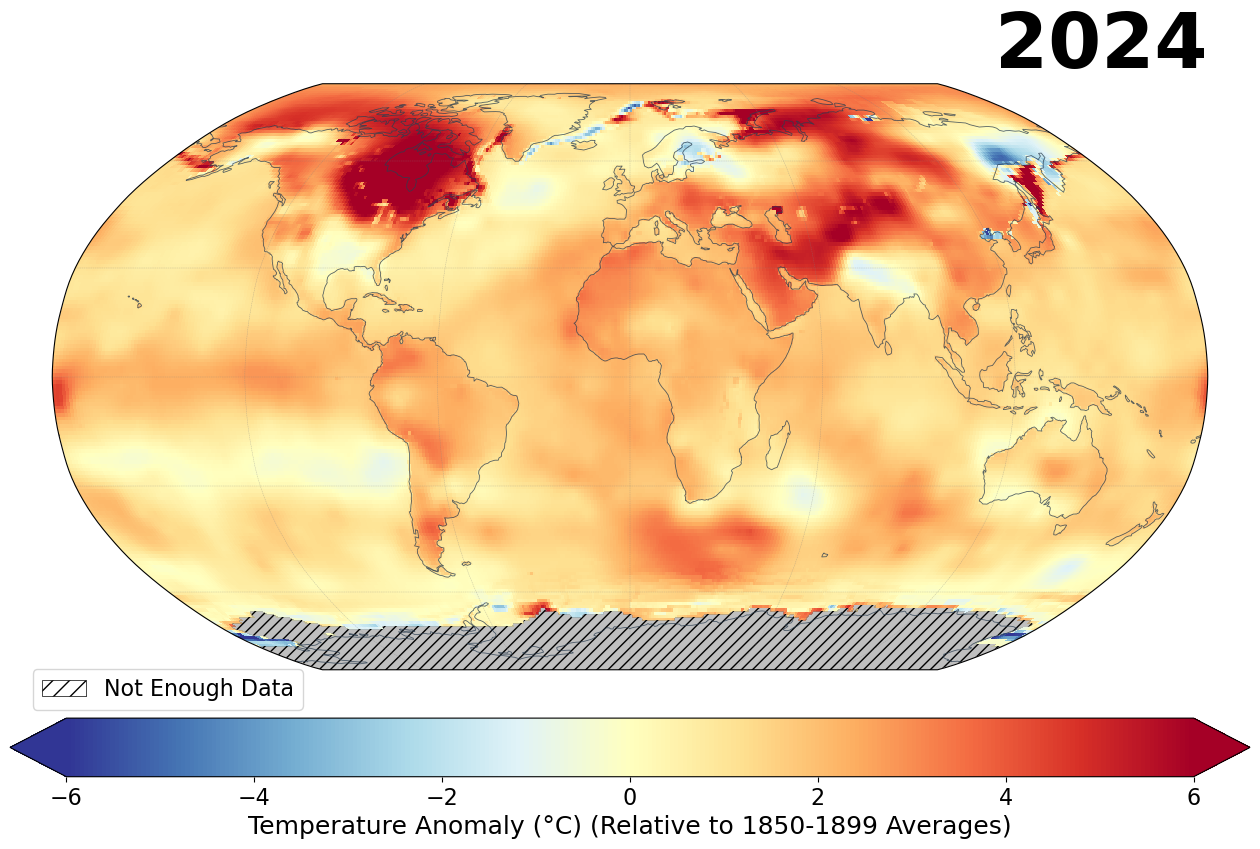

In [88]:
 # Create figure
fig = plt.figure(figsize=(16, 9), facecolor='white')

# Create GridSpec: 2 rows, map gets most space
gs = gridspec.GridSpec(2, 1, height_ratios=[20, 2], hspace=0.15)

# Map axis
ax = fig.add_subplot(gs[0], projection=ccrs.Robinson())

# Add ocean color
# ax.add_feature(cfeature.OCEAN, facecolor='#d4e6f1', zorder=0)

# Plot data WITHOUT colorbar
plot = data_ds_anom_final.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='RdYlBu_r',
    vmin=-6,
    vmax=6,
    add_colorbar=False  # We'll add it manually
)


# hatch(ax, xr.where()


add_data_clarity_legend(ax, fontsize=16, bbox_to_anchor=(0.1, 0.02))

# Refined coastlines
ax.coastlines(linewidth=0.6, color='#2c3e50', alpha=0.8)

# Gridlines
ax.gridlines(linewidth=0.3, linestyle='--', alpha=0.5, color='gray')

# Set global extent
ax.set_global()

# Title
ax.set_title(None)
year = data_ds_anom.isel(time=-1).time.dt.year.values
ax.set_title(f'{year}', fontsize=55, loc='right', pad=10, fontweight='bold')

# Colorbar axis
cax = fig.add_subplot(gs[1])

# Add colorbar to its own axis
cbar = plt.colorbar(plot, cax=cax, orientation='horizontal', extend='both')
cbar.set_label('Temperature Anomaly (°C) (Relative to 1850-1899 Averages)', fontsize=18)
cbar.ax.tick_params(labelsize=16)

# # Baseline text
# ax.text(0.02, -0.05, 'Relative to 1850-1899 Averages', 
#         transform=ax.transAxes, fontsize=18, alpha=0.7,
#         verticalalignment='bottom')

hatch(ax, xr.where(np.isfinite(data_ds_anom_final), 0, 1),
      hatches=['///', ''], colors=['grey', 'none'], alpha=0.5)